## 1. Попробуйте изменить параметры нейронной сети, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) или любым любимым временным рядом так, чтобы улучшить её точность. Приложите анализ

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import datetime

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# %load_ext tensorboard

In [4]:
# %reload_ext tensorboard

Читаем данные из файла со значениями (потребление энергии дневные отсчеты)

In [5]:
df = pd.read_csv('airline-passengers.csv')
df.index = df.Month
df.reset_index(drop=True, inplace=True)

Данные о потреблении энергии+ индексы (дата)

In [6]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


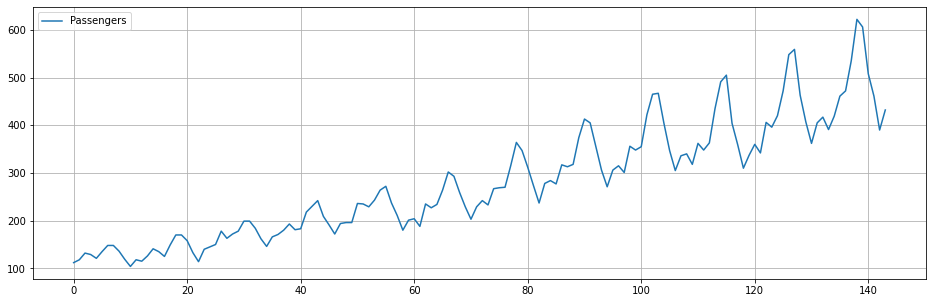

In [7]:
df.plot( figsize = (16,5))
plt.grid('On')
plt.show()

In [8]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
df_train = df.iloc[:100, :]
df_train.sort_values(by="Month", ascending=True).head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
df_train['Month'] = pd.to_datetime(df_train.Month)

df_train.Month = df_train.Month.dt.month

In [11]:
df_train.head()

,Month,Passengers
0,1,112
1,2,118
2,3,132
3,4,129
4,5,121


In [12]:
X_train, y_train = df_train, df_train.Passengers

In [13]:
xLEN = 4
batch_size = 5
epochs = 10

train_data = keras.preprocessing.timeseries_dataset_from_array(
    X_train.iloc[:-xLEN,:],
    y_train[xLEN:],
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size
)

In [14]:
for batch in train_data.take(2):
    inputs, targets = batch

In [15]:
targets[0]

<tf.Tensor: shape=(), dtype=int64, numpy=119>

In [16]:
inputs[1,:,:]

<tf.Tensor: shape=(4, 2), dtype=int64, numpy=
array([[  7, 148],
       [  8, 148],
       [  9, 136],
       [ 10, 119]])>

### Тестовая выборка

In [17]:
df_test = df_train = df.iloc[100:, :]
df_test.head()

,Month,Passengers
100,1957-05,355
101,1957-06,422
102,1957-07,465
103,1957-08,467
104,1957-09,404


In [18]:
df_test['Month'] = pd.to_datetime(df_test.Month)

df_test.Month = df_test.Month.dt.month

In [19]:
X_test, y_test = df_test, df_test.Passengers

In [20]:
X_test.head()

,Month,Passengers
100,5,355
101,6,422
102,7,465
103,8,467
104,9,404


### Подготовим данные для обучения и валидации

In [21]:
data = X_train.copy() # берем все что есть

In [22]:
data.shape[1]

2

In [23]:
data.head()

,Month,Passengers
0,1,112
1,2,118
2,3,132
3,4,129
4,5,121


Делаем нормализацию

In [24]:
val_split = 20
scaler = StandardScaler()
data_v = scaler.fit(data[:val_split])
 
data_f = pd.DataFrame(scaler.transform(data))

Создаем данные для обучения

In [25]:
# список признаков, по которым будем учить
channelIndexes = [0, 1]

# длина теста
valLen = 20

# отступ тестов от тренировок
bias = 3

# вычисляем точку разделения ряда на тесты и тренировку
train_split = data_f.shape[0] - valLen - bias
train_split
# # делим
train_data = data_f.iloc[0 : train_split ,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]

In [26]:
train_data.head(7)

,0,1
0,-1.470906,-1.181840
1,-1.157947,-0.836777
2,-0.844989,-0.031631
3,-0.532030,-0.204162
4,-0.219071,-0.664246
5,0.093888,0.140901
6,0.406846,0.888537


In [27]:
val_data.head(3)

,0,1
80,1.032764,10.320251
81,1.345723,8.134854
82,1.658681,6.006967


Формируем параметры для генерации выборки

In [28]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLEN
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
# batch_size = 5
epochs = 10


Выделяем части на обучение и проверку

In [29]:
Chanel_numb = len(channelIndexes)

start = xLEN + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLEN+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLEN-1:,1].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLEN / step)


x_end = len(val_data) - xLEN - future 

label_start = len(train_data)+bias+xLEN + future +1

xVal_df = val_data.iloc[:-future-xLEN+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLEN-1:,1].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [30]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(73, 2)
(73,)
(16, 2)
(16,)


Посмотрим на них

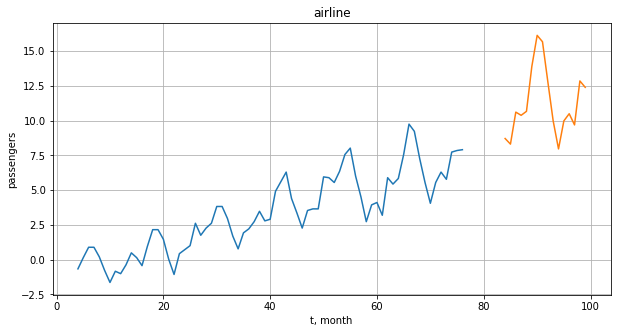

In [31]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLEN:yTrain.shape[0]+xLEN],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+bias+future+2*xLEN-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, month')
plt.ylabel('passengers')
plt.title('airline')
plt.show()

Используем механизм формирования пакетов для обучения

In [32]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size,
)


In [33]:
for batch in dataset_val.take(2):
    inputs, targets = batch

In [34]:
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (5, 4, 2)
Target shape: (5,)


In [35]:
inputs[1,:,:]

<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[-0.84498868, 10.60780356],
       [-0.53202991, 10.37776174],
       [-0.21907114, 10.66531401],
       [ 0.09388763, 13.88589953]])>

In [36]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=13.885899534145489>

In [37]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

**сеть:  LSTM слои+Conv1D +Dense слой.**

In [38]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 64)             17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 64)             33024     
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 64)             12352     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 62,919
Trainable params: 62,919
Non-trainable params: 0
____________________________________________________

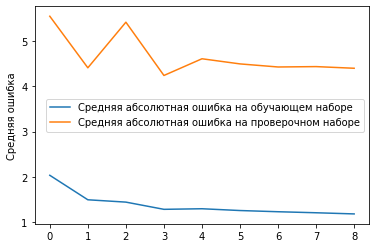

In [39]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback], verbose=0)


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [40]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

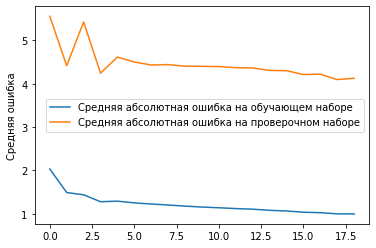

In [41]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback], verbose=0)

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [42]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

In [43]:
yVal.shape, predVal.shape

((16,), (13,))

Валидация:

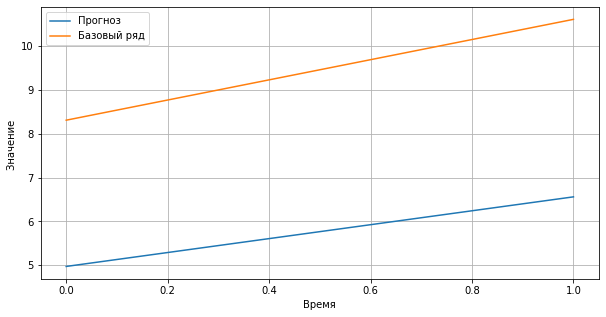

In [44]:
start = 1
step = 2
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Тренировочные даннные:

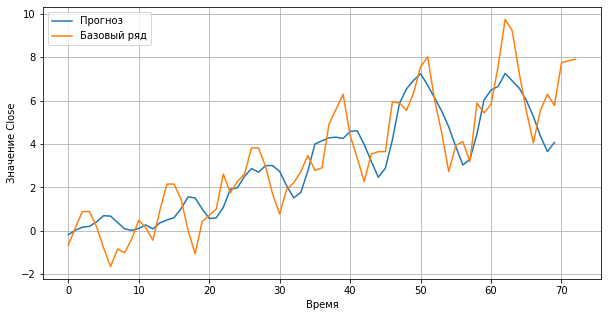

In [45]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Проверяем качество модели:
- оценим по лаговой корреляции рядов a, b;
- если наибольшая корреляция с лагом 0, то отлично;
- есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).


In [46]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

In [47]:
start = 1
step = 3

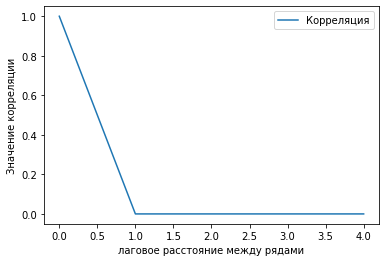

In [48]:
corr = []
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

In [49]:
corr

[1.0000024697331902, 0, 0, 0, 0]

### Если честно, то с рядами мало, что понятно..

## 2. Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения

In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku 
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers

Разбор текста - Токенизация

In [51]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(
                num_words=10000,
                filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'",
                lower=True, split=' ')
data = open('alice_in_wonderland.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

In [52]:
corpus[80:100]

['hung upon pegs. she took down a jar from one of the shelves as',
 'she passed; it was labelled ‘orange marmalade’, but to her great',
 'disappointment it was empty: she did not like to drop the jar for fear',
 'of killing somebody, so managed to put it into one of the cupboards as',
 'she fell past it.',
 '',
 '‘well!’ thought alice to herself, ‘after such a fall as this, i shall',
 'think nothing of tumbling down stairs! how brave they’ll all think me at',
 'home! why, i wouldn’t say anything about it, even if i fell off the top',
 'of the house!’ (which was very likely true.)',
 '',
 'down, down, down. would the fall never come to an end! ‘i wonder how',
 'many miles i’ve fallen by this time?’ she said aloud. ‘i must be getting',
 'somewhere near the centre of the earth. let me see: that would be four',
 'thousand miles down, i think--’ (for, you see, alice had learnt several',
 'things of this sort in her lessons in the schoolroom, and though this',
 'was not a very good opportuni

Исполним токенизацию и кодирование

In [53]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [54]:
token_list

[3397, 4, 367, 1307, 3398, 4, 278, 38, 497, 622]

In [55]:
tokenizer.index_word[30]

'but'

In [56]:
tokenizer.word_index['love']

1065

In [57]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         22, 444,  31,  24,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22,
        444,  31,  24,   1, 150],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,
         31,  24,   1, 150,   6],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,  31,
         24,   1, 150,   6, 707]], dtype=int32)

In [58]:
label.shape

(28231, 3399)

Создаем сеть

In [59]:
callback = EarlyStopping(monitor='val_loss', patience=10) # создаем обратный вызов - calback - тут "Ранний останов"

In [60]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(128))
model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 256)           870144    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1699)              219171    
_________________________________________________________________
dense_3 (Dense)              (None, 3399)              5778300   
Total params: 7,064,735
Trainable params: 7,064,735
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
history = model.fit(predictors,
                    label,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[callback],
                    verbose=0)

Тест


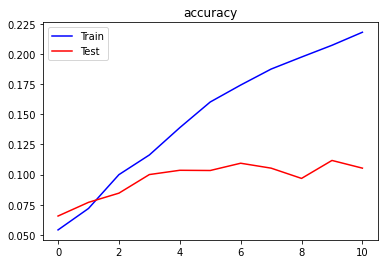

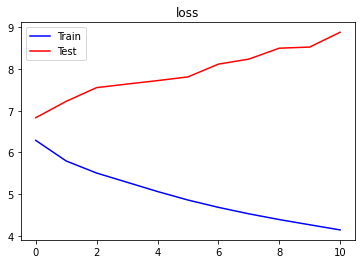

In [62]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

Строим тест генератора

In [63]:
# начальная строка
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
    predicted = model.predict_classes(token_list, verbose=0)
  # 
    output_word = ""
    # добавим новое слово в последовательность
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

[360, 69, 11, 1311, 80, 107, 841]
[360, 69, 11, 1311, 80, 107, 841, 2]
[360, 69, 11, 1311, 80, 107, 841, 2, 9]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33, 85]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33, 85, 55]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33, 85, 55, 5]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33, 85, 55, 5, 32]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33, 85, 55, 5, 32, 32]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33, 85, 55, 5, 32, 32, 32]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33, 85, 55, 5, 32, 32, 32, 32]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33, 85, 55, 5, 32, 32, 32, 32, 32]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 33, 85, 55, 5, 32, 32, 32, 32, 32, 32]
Help me Obi Wan Kenobi, you're my only hope ’ said the gryphon ‘i don’t have a little little little little little li

Посмотрим на предсказание через вероятные ответы (не олно слово имеет большую вероятность)

In [64]:
y_p=model.predict(token_list)

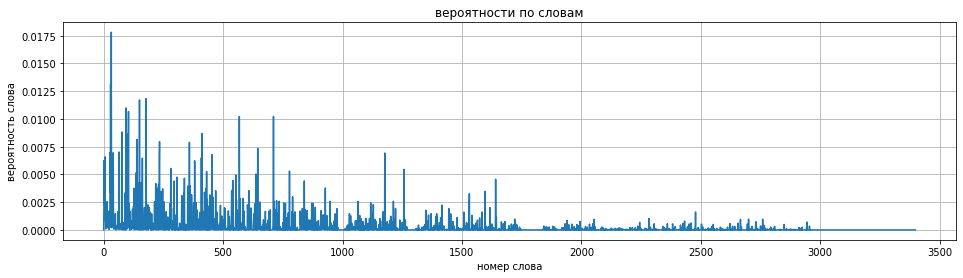

In [65]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [66]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([], dtype=int64)

In [67]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

In [68]:
seed_text = "She is my girl, I see in"
next_words = 15
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p=model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[7, 31, 80, 840, 15, 65, 10]
[7, 31, 80, 840, 15, 65, 10, 5]
[7, 31, 80, 840, 15, 65, 10, 5, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32, 104]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32, 104, 3]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32, 104, 3, 31]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32, 104, 3, 31, 4]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32, 104, 3, 31, 4, 25]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32, 104, 3, 31, 4, 25, 5]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32, 104, 3, 31, 4, 25, 5, 29]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32, 104, 3, 31, 4, 25, 5, 29, 359]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 177, 32, 104, 3, 31, 4, 25, 5, 29, 359, 6]
She is my girl, I see in a little little good little thing and is to be a very deal of all


### Даже получилось что-то вменяемое.
### Построим более сложную модель.

In [69]:
model2 = Sequential()
model2.add(Embedding(total_words, 256, input_length=max_sequence_len-1))

model2.add(LSTM(128, return_sequences="True"))
model2.add(LSTM(64, return_sequences="True"))
model2.add(Conv1D(32, 3, activation="linear"))
model2.add(Conv1D(16, 1, activation="linear"))
model2.add(Dropout( 0.2))
model2.add(Flatten())
model2.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(total_words, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())

# model2.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(64, 1, activation="linear"))
# model2.add(Flatten())                        


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 256)           870144    
_________________________________________________________________
lstm_3 (LSTM)                (None, 17, 128)           197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 17, 64)            49408     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 32)            6176      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 16)            528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 240)              

In [70]:
history = model2.fit(predictors,
                    label,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[callback],
                    verbose=0)

Тест


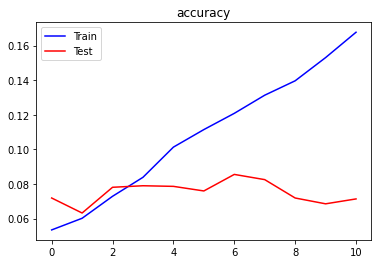

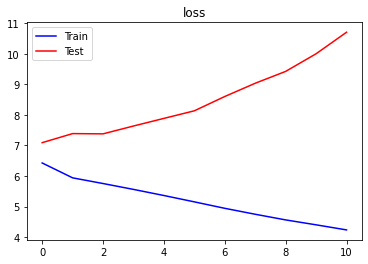

In [71]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

Строим тест генератора

In [72]:
# начальная строка
seed_text = "She is my girl, I see in"
next_words = 15
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
    predicted = model2.predict_classes(token_list, verbose=0)
  # 
    output_word = ""
    # добавим новое слово в последовательность
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

[7, 31, 80, 840, 15, 65, 10]
[7, 31, 80, 840, 15, 65, 10, 2]
[7, 31, 80, 840, 15, 65, 10, 2, 9]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33, 50]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33, 50, 5]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33, 50, 5, 2085]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33, 50, 5, 2085, 6]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33, 50, 5, 2085, 6, 1430]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33, 50, 5, 2085, 6, 1430, 6]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33, 50, 5, 2085, 6, 1430, 6, 1340]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33, 50, 5, 2085, 6, 1430, 6, 1340, 4]
[7, 31, 80, 840, 15, 65, 10, 2, 9, 1, 87, 33, 50, 5, 2085, 6, 1430, 6, 1340, 4, 112]
She is my girl, I see in ’ said the gryphon ‘i were a “edwin of morcar of milk to looked why


Посмотрим на предсказание через вероятные ответы (не олно слово имеет большую вероятность)

In [73]:
y_p=model2.predict(token_list)

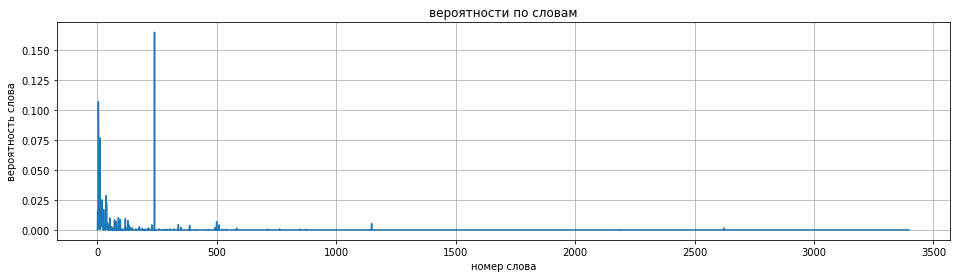

In [74]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [75]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([  4,   5,   8,  10, 239])

In [76]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

to  :  0.106808364
a  :  0.081345186
it  :  0.047106624
in  :  0.076628804
why  :  0.16479063


### С текстом понимания побольше. Но не понятно, как улучшить сеть, потому что все зависит от того, что хочется получить. По-моему, здесь вышло даже не так уж плохо :)